<a href="https://colab.research.google.com/github/YASH212414/backorder-prediction/blob/main/Backorderprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Import and view the data

In [ ]:
#Set working directory
os.chdir("/content/drive/MyDrive/PROJECT (Backorder prediction)")


In [ ]:
# Datasets
a = pd.read_csv("Training_Dataset_v2.csv")
b = pd.read_csv("Test_Dataset_v2.csv")

<ipython-input-32-c966e41040e4>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv("Training_Dataset_v2.csv")
<ipython-input-32-c966e41040e4>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  b = pd.read_csv("Test_Dataset_v2.csv")


In [ ]:
#Combine into one dataset
merged = pd.concat([a,b])


#                 Column Description

*  sku - Random ID for the product
*  national_inv - Current inventory level for the part
*  lead_time - Transit time for product (if available)
*  in_transit_qty - Amount of product in transit from source
* forecast_3_month - Forecast sales for the next 3 months
* forecast_6_month - Forecast sales for the next 6 months
* forecast_9_month - Forecast sales for the next 9 months
* sales_1_month - Sales quantity for the prior 1 month time period
* sales_3_month - Sales quantity for the prior 3 month time period
* sales_6_month - Sales quantity for the prior 6 month time period
* sales_9_month - Sales quantity for the prior 9 month time period
* min_bank - Minimum recommend amount to stock
* potential_issue - Source issue for part identified
* pieces_past_due - Parts overdue from source
* perf_6_month_avg - Source performance for prior 6 month period
* perf_12_month_avg - Source performance for prior 12 month period
* local_bo_qty - Amount of stock orders overdue
* deck_risk - Part risk flag
* oe_constraint - Part risk flag
* ppap_risk - Part risk flag
* stop_auto_buy - Part risk flag
* rev_stop - Part risk flag
* went_on_backorder - Product actually went on backorder. This is the target value.

In [ ]:
# Display first 5 entries
print(merged.head(5).transpose())

                         0        1        2        3        4
sku                1026827  1043384  1043696  1043852  1044048
national_inv           0.0      2.0      2.0      7.0      8.0
lead_time              NaN      9.0      NaN      8.0      NaN
in_transit_qty         0.0      0.0      0.0      0.0      0.0
forecast_3_month       0.0      0.0      0.0      0.0      0.0
forecast_6_month       0.0      0.0      0.0      0.0      0.0
forecast_9_month       0.0      0.0      0.0      0.0      0.0
sales_1_month          0.0      0.0      0.0      0.0      0.0
sales_3_month          0.0      0.0      0.0      0.0      0.0
sales_6_month          0.0      0.0      0.0      0.0      0.0
sales_9_month          0.0      0.0      0.0      0.0      4.0
min_bank               0.0      0.0      0.0      1.0      2.0
potential_issue         No       No       No       No       No
pieces_past_due        0.0      0.0      0.0      0.0      0.0
perf_6_month_avg     -99.0     0.99    -99.0      0.1  

# Basic Data Manipulation

In [ ]:
#recode binary variables as 0 / 1 rather than No / Yes
for col in ['potential_issue',
            'deck_risk',
            'oe_constraint',
            'ppap_risk',
            'stop_auto_buy',
            'rev_stop',
            'went_on_backorder']:
    merged[col]=pd.factorize(merged[col])[0]

In [ ]:
# Remove rows with all NA's
merged.dropna(subset=['national_inv'], inplace=True)


In [ ]:
# Change placeholder values to NA for specific columns
merged['perf_6_month_avg'].replace(-99, np.NaN, inplace=True)
merged['perf_12_month_avg'].replace(-99, np.NaN, inplace=True)

In [ ]:
quant_vars=['national_inv',
           'lead_time',
           'in_transit_qty',
           'forecast_3_month',
           'forecast_6_month',
           'forecast_9_month',
           'sales_1_month',
           'sales_3_month',
           'sales_6_month',
           'sales_9_month',
           'min_bank',
           'pieces_past_due',
           'perf_6_month_avg',
           'perf_12_month_avg',
           'local_bo_qty']

In [ ]:
cat_vars=['potential_issue',
            'deck_risk',
            'oe_constraint',
            'ppap_risk',
            'stop_auto_buy',
            'rev_stop',
            'went_on_backorder']

In [ ]:
# Exclude the target variable from predictor categorical variables
cat_pred = cat_vars[:-1]

# Descriptive Statistics and Plots

## Quantitative variables

In [ ]:
# Summary of quantitative variables (horizontal)
print(merged[quant_vars].describe())

# Means by backorder status (horizontal)
print(merged.groupby('went_on_backorder')[quant_vars].mean().transpose())


       national_inv     lead_time  in_transit_qty  forecast_3_month  \
count  1.929935e+06  1.814318e+06    1.929935e+06      1.929935e+06   
mean   4.965683e+02  7.878627e+00    4.306440e+01      1.785399e+02   
std    2.957343e+04  7.054212e+00    1.295420e+03      5.108770e+03   
min   -2.725600e+04  0.000000e+00    0.000000e+00      0.000000e+00   
25%    4.000000e+00  4.000000e+00    0.000000e+00      0.000000e+00   
50%    1.500000e+01  8.000000e+00    0.000000e+00      0.000000e+00   
75%    8.000000e+01  9.000000e+00    0.000000e+00      4.000000e+00   
max    1.233440e+07  5.200000e+01    4.894080e+05      1.510592e+06   

       forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
count      1.929935e+06      1.929935e+06   1.929935e+06   1.929935e+06   
mean       3.454659e+02      5.066067e+02   5.536816e+01   1.746639e+02   
std        9.831562e+03      1.434543e+04   1.884377e+03   5.188856e+03   
min        0.000000e+00      0.000000e+00   0.000000e+00   0

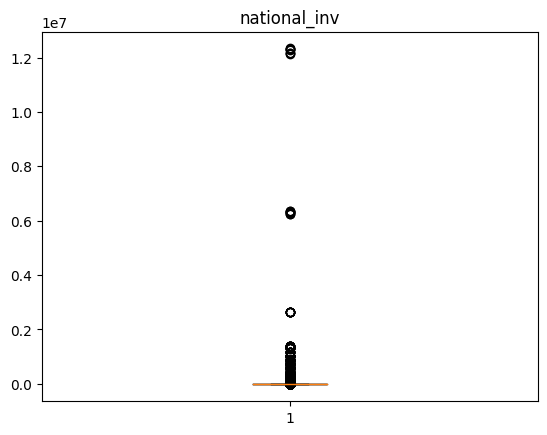

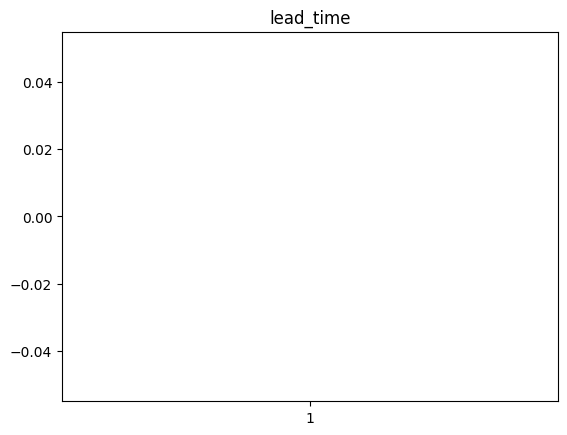

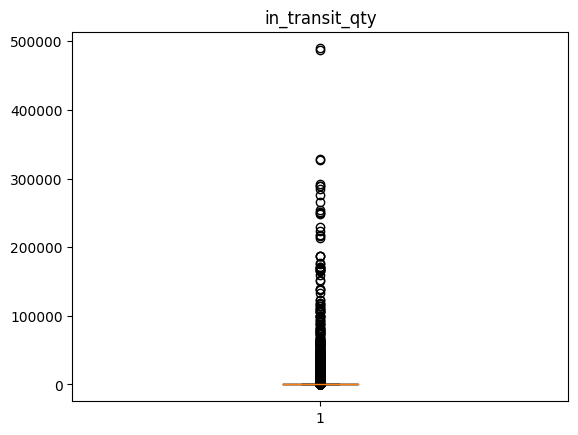

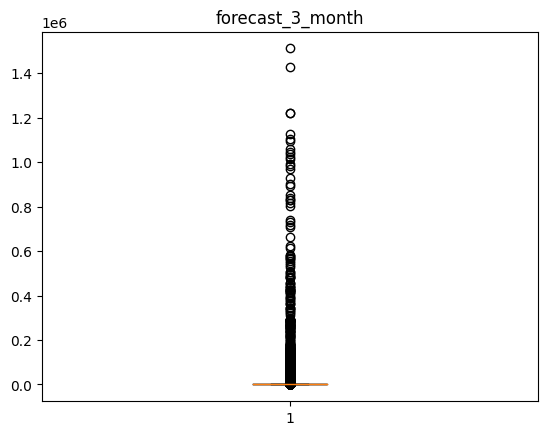

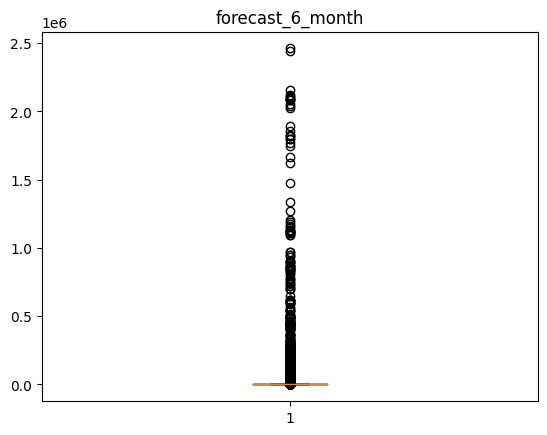

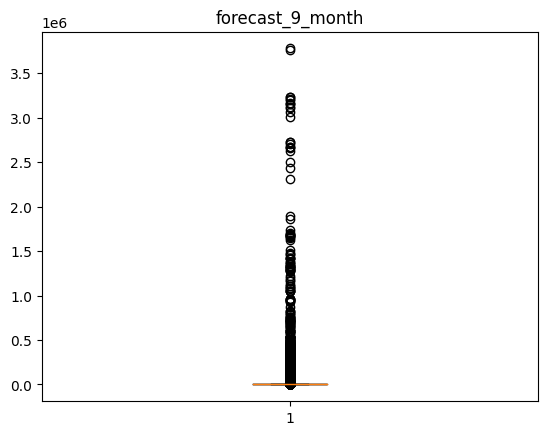

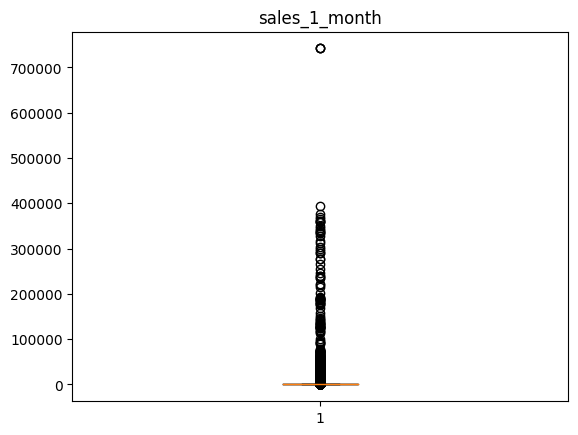

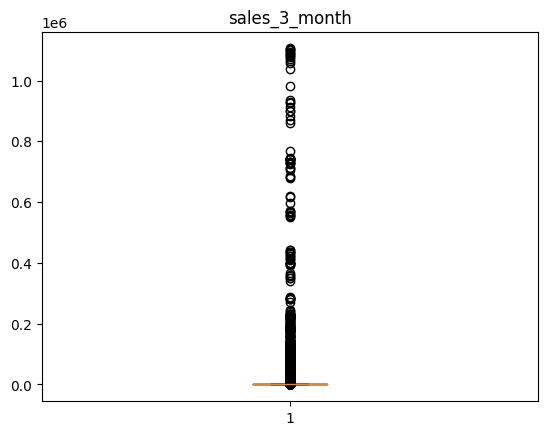

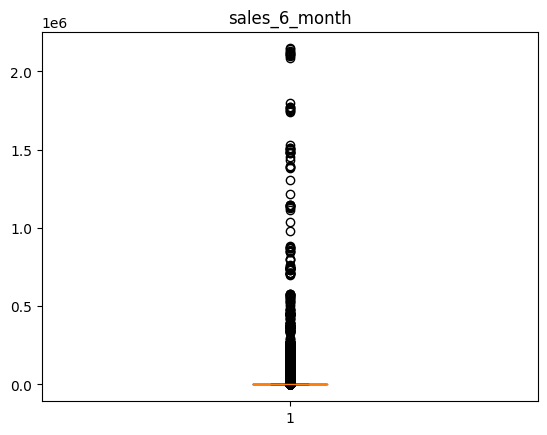

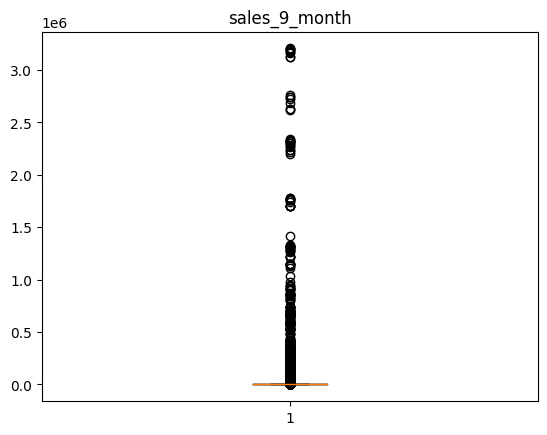

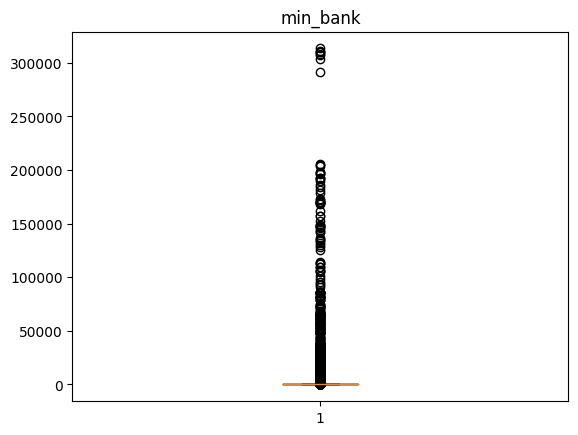

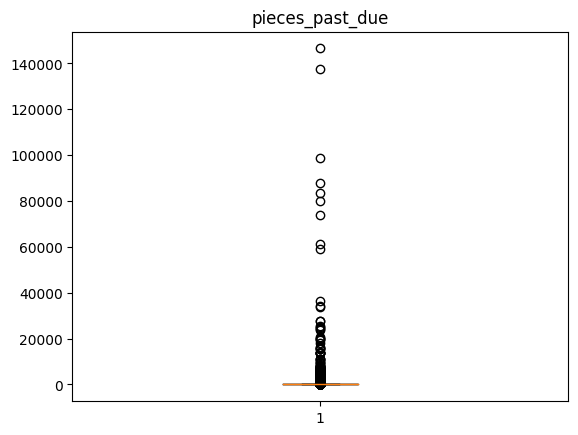

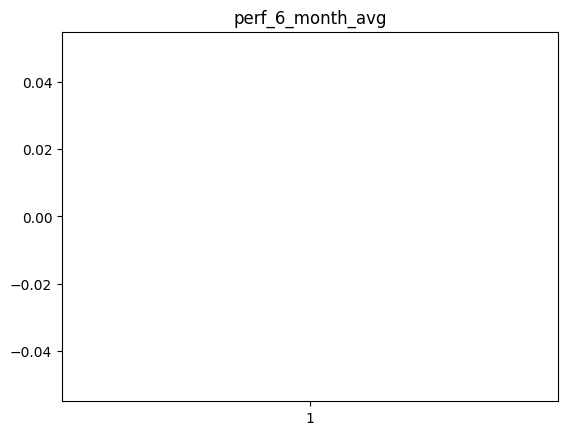

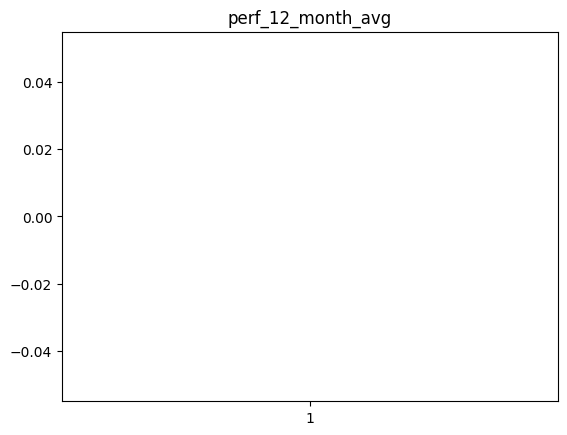

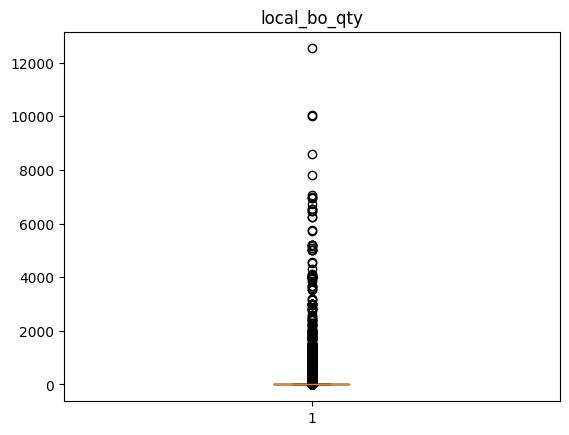

In [ ]:
# Boxplots of quantitative variables
for col in quant_vars:
    plt.boxplot(merged[col])
    plt.title(col)
    plt.show()


## Categorical variables

In [ ]:
# Percentage of each categorical variable
for col in cat_vars:
    print(col, ": ", round(merged[col].mean() * 100, 2), "%")


potential_issue :  0.05 %
deck_risk :  22.56 %
oe_constraint :  0.02 %
ppap_risk :  12.05 %
stop_auto_buy :  3.66 %
rev_stop :  0.04 %
went_on_backorder :  0.72 %


In [ ]:
# Proportions stratified by went_on_backorder
print(merged.groupby('went_on_backorder')[cat_pred].mean())

                   potential_issue  deck_risk  oe_constraint  ppap_risk  \
went_on_backorder                                                         
0                         0.000488   0.226089       0.000148   0.120264   
1                         0.003862   0.162864       0.000644   0.152421   

                   stop_auto_buy  rev_stop  
went_on_backorder                           
0                       0.036518  0.000436  
1                       0.041342  0.000286  


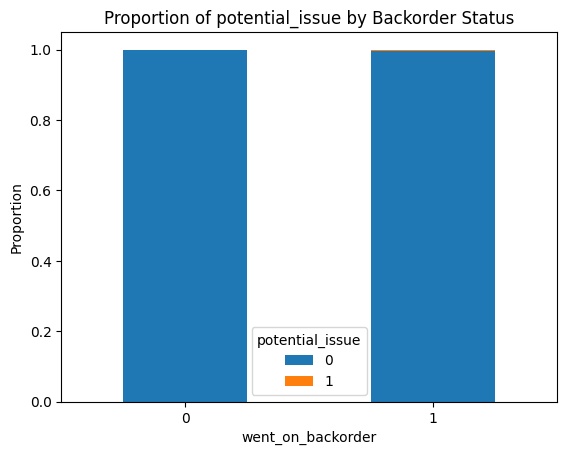

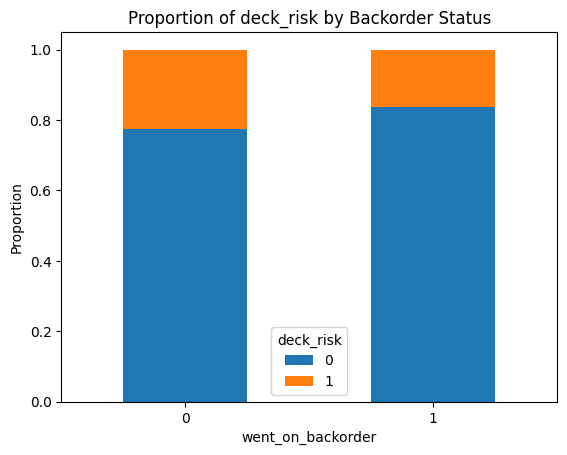

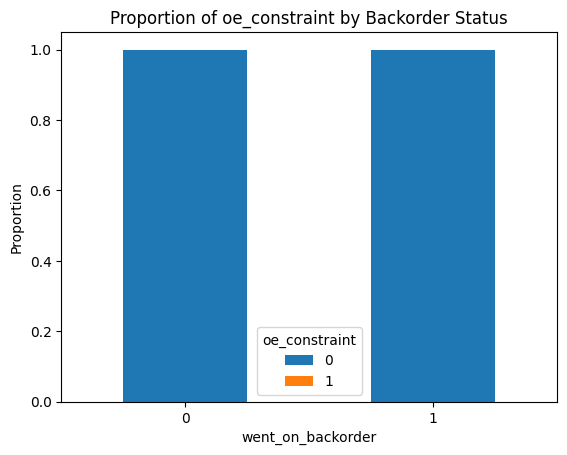

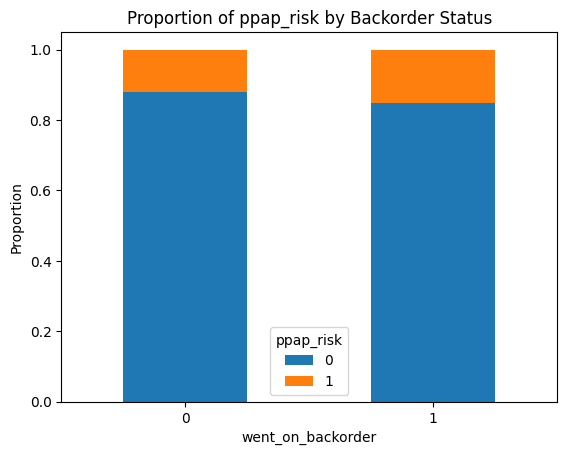

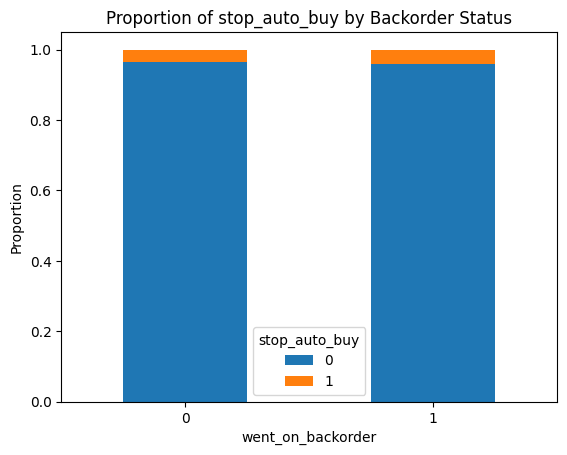

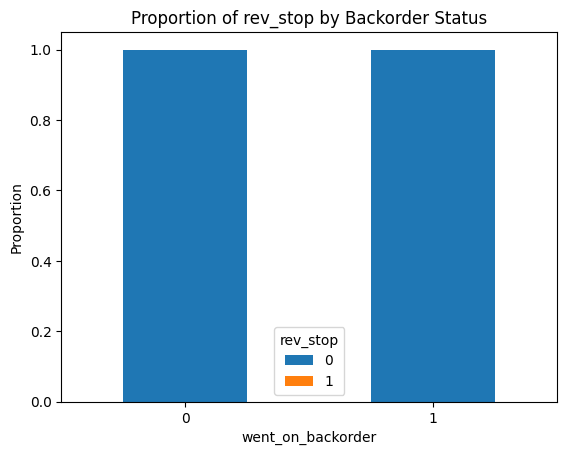

In [ ]:
#barplots of proportions stratified by went_on_backorder
# Assuming catpred is a list of categorical predictor variables
for col in cat_pred:
    # Calculate proportions for each category stratified by 'went_on_backorder'
    proportions = merged.groupby('went_on_backorder')[col].value_counts(normalize=True).unstack()

    # Plotting
    proportions.plot(kind='bar', stacked=True)
    plt.ylabel('Proportion')
    plt.title("Proportion of {} by Backorder Status".format(col))
    plt.xticks(rotation=0)
    plt.legend(title=col)
    plt.show()

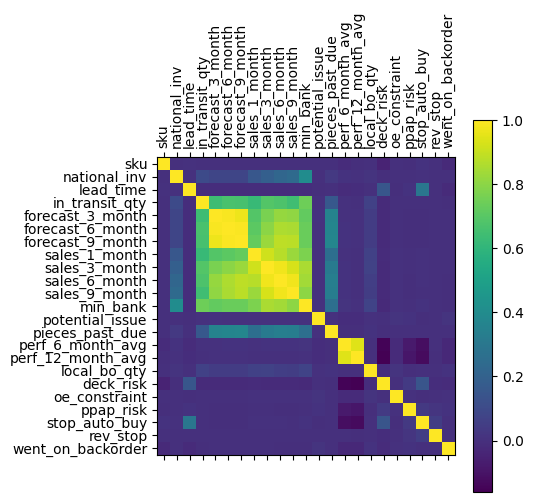

In [ ]:
# Correction Matrix Plot of all variables
correlations = merged.corr()
plt.matshow(correlations)
plt.xticks(range(len(merged.columns)), merged.columns, rotation=90)
plt.yticks(range(len(merged.columns)), merged.columns)
plt.colorbar()
plt.show()



# Missing Data

In [ ]:
# Missing Data
missing_data = merged.isnull().sum()
missing_percent = (missing_data / len(merged)) * 100
missing_info = pd.DataFrame({'Missing_Count': missing_data, 'Missing_Percentage': missing_percent})
print(missing_info)

                   Missing_Count  Missing_Percentage
sku                            0            0.000000
national_inv                   0            0.000000
lead_time                 115617            5.990720
in_transit_qty                 0            0.000000
forecast_3_month               0            0.000000
forecast_6_month               0            0.000000
forecast_9_month               0            0.000000
sales_1_month                  0            0.000000
sales_3_month                  0            0.000000
sales_6_month                  0            0.000000
sales_9_month                  0            0.000000
min_bank                       0            0.000000
potential_issue                0            0.000000
pieces_past_due                0            0.000000
perf_6_month_avg          148579            7.698653
perf_12_month_avg         140025            7.255426
local_bo_qty                   0            0.000000
deck_risk                      0            0.

In [ ]:
# Create a variable for any missing data
merged['anymissing'] = ((pd.isnull(merged['perf_6_month_avg'])) |
                        (pd.isnull(merged['perf_12_month_avg'])) |
                        (pd.isnull(merged['lead_time']))).astype(int)

 ## Compare complete data to data with any missing variables
*    Means of quantitative variables
*    Proportions of categorical variables




In [ ]:
# Compare complete data to data with any missing variables
print(merged.groupby('anymissing')[quant_vars].mean())
print(merged.groupby('anymissing')[cat_vars].mean())

            national_inv  lead_time  in_transit_qty  forecast_3_month  \
anymissing                                                              
0             378.984118   7.783747       44.235561        190.816173   
1            1906.318053  13.006159       29.022978         31.355690   

            forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
anymissing                                                                     
0                 368.979564        540.913775      55.902779     176.628317   
1                  63.553786         95.290021      48.958514     151.111389   

            sales_6_month  sales_9_month   min_bank  pieces_past_due  \
anymissing                                                             
0              349.037103     537.452417  51.809120         2.134941   
1              251.984358     357.221882  64.372953         0.592493   

            perf_6_month_avg  perf_12_month_avg  local_bo_qty  
anymissing                       

In [ ]:
# Impute the medians
merged.fillna(merged.median(), inplace=True)

# Modeling

In [ ]:
# 10-fold Cross Validation
merged_pred = pd.DataFrame()

kf = KFold(n_splits=10, shuffle=True, random_state=123)


In [ ]:
# Iterate over folds
for train_index, test_index in kf.split(merged):
    # Define Training data
    merged_train = merged.iloc[train_index]
    y_train = merged_train['went_on_backorder']
    X_train = merged_train.drop(['sku', 'went_on_backorder'], axis=1)

    # Define Test data
    merged_test = merged.iloc[test_index]
    y_test = merged_test['went_on_backorder']
    X_test = merged_test.drop(['sku', 'went_on_backorder'], axis=1)

    # Split Data by Class
    train_majority = merged_train[y_train == 0]
    train_minority = merged_train[y_train == 1]

    # Determine Sample Size
    n_minority = len(train_minority)

    # Downsample Majority Class
    train_majority_downsampled = resample(train_majority,
                                          replace=False,
                                          n_samples=n_minority,
                                          random_state=123)

    # Concatenate Data
    train_downsampled = pd.concat([train_majority_downsampled, train_minority])

    # Separate Features and Target
    y_train_downsampled = train_downsampled['went_on_backorder']
    X_train_downsampled = train_downsampled.drop(['sku', 'went_on_backorder'], axis=1)

# --------------------------------------------------------------- #

In [ ]:
# Impute missing values with the median
merged.fillna(merged.median(), inplace=True)

# Define the 'fitrandomforests' function outside the loop
def fitrandomforests(n_est, maxfeat, minleaf):
    varname = "pred_nest%s_feat%s_leaf%s" % (n_est, maxfeat, minleaf)
    varname2 = "pred_down_nest%s_feat%s_leaf%s" % (n_est, maxfeat, minleaf)
    rf = RandomForestClassifier(n_estimators=n_est, max_features=maxfeat, min_samples_leaf=minleaf)
    rf.fit(X_train, y_train)
    preds = rf.predict_proba(X_test)[:, 1]
    merged_test[varname] = preds
    rfd = RandomForestClassifier(n_estimators=n_est, max_features=maxfeat, min_samples_leaf=minleaf)
    rfd.fit(X_train_downsampled, y_train_downsampled)
    predsd = rfd.predict_proba(X_test)[:, 1]
    merged_test[varname2] = predsd

In [ ]:
# Tuning parameter grids
# Number of trees (more is better for prediction but slower)
n_est = 50
# Maximum features tried
maxfeatgrid = [3, 5, 7]
# Minimum samples per leaf
minleafgrid = [5, 10, 30]

# Fit models
for feat in maxfeatgrid:
    for leaf in minleafgrid:
        fitrandomforests(n_est, feat, leaf)
        # Combine predictions for this fold with previous folds
        merged_pred = pd.concat([merged_pred, merged_test])

# Drop NA's from dataframe caused by the method for combining datasets from each loop iteration
merged_pred = merged_pred.dropna()


<ipython-input-53-b463d93a45b3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test[varname] = preds
<ipython-input-53-b463d93a45b3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test[varname2] = predsd
<ipython-input-53-b463d93a45b3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

  # --------------------------------------------------------------- #

#ROC Curves #

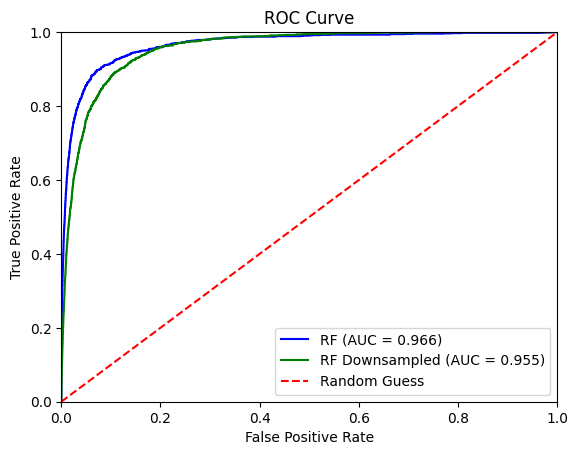

In [ ]:
# ROC Curves
fpr, tpr, thresholds = roc_curve(merged_pred['went_on_backorder'], merged_pred['pred_nest50_feat3_leaf5'])
fpr2, tpr2, thresholds2 = roc_curve(merged_pred['went_on_backorder'], merged_pred['pred_down_nest50_feat7_leaf5'])
roc_auc = roc_auc_score(merged_pred['went_on_backorder'], merged_pred['pred_nest50_feat3_leaf5'])
roc_auc2 = roc_auc_score(merged_pred['went_on_backorder'], merged_pred['pred_down_nest50_feat7_leaf5'])
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='RF (AUC = %0.3f)' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label='RF Downsampled (AUC = %0.3f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


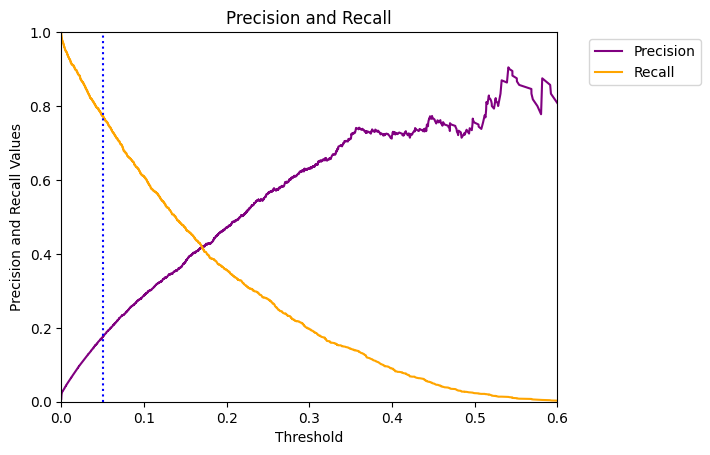

In [ ]:
#Precision and Recall

#Precision: The proportion of predicted backorders that actually go on backorder
#Recall: The proportion of backordered items that are predicted to go on backorder

#define precision, recall, and corresponding threshold for model with hightest AUC
precision, recall, threshold = precision_recall_curve(merged_pred['went_on_backorder'],merged_pred['pred_nest50_feat3_leaf5'])

#plot Precision and Recall for a given threshold.
plt.title('Precision and Recall')
plt.plot(threshold, precision[1:], 'purple', label='Precision')
plt.plot(threshold, recall[1:], 'orange', label='Recall')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.xlim([0, .6])
plt.ylim([0, 1])
plt.axvline(x=.05, linestyle=":", color="blue")
plt.ylabel('Precision and Recall Values')
plt.xlabel('Threshold')
plt.show()





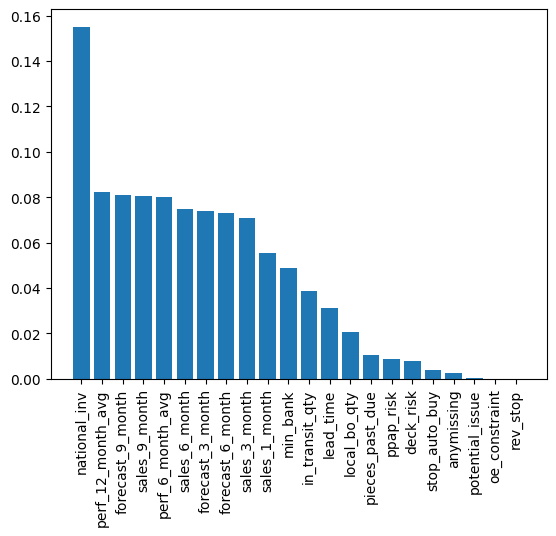

In [ ]:
#Fit model on entire dataset,
rf=RandomForestClassifier(n_estimators=10,
                          max_features=3,
                          min_samples_leaf=5)
y=merged['went_on_backorder']
X=merged.drop(['sku','went_on_backorder'],axis=1)
rf.fit(X,y)

#importance of variables
list(zip(list(X),rf.feature_importances_))
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=X.columns,columns=["Importance"])
importance["Std"] = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)
importance=importance.sort_values(['Importance'],ascending=False)

#plot importances
xlim = range(importance.shape[0])
plt.bar(xlim, importance['Importance'], yerr=importance['Std'], align="center")
plt.xticks(range(0,22), importance.index,rotation=90)
plt.show()